## Import modules

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy import constants
from scipy.optimize import leastsq
from scipy.interpolate import interp1d
from scipy import stats
from lmfit import minimize, Parameters, report_fit
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

## Sort Data

In [195]:
data1 = pd.read_csv("../Data/GrowthRespPhotoData_new.csv", low_memory = False)


# get rid of 0s -ves and NAs from data (only +ves)
data2 = data1.iloc[data1.index[data1["StandardisedTraitValue"] > 0]]

# get rid of ids with < 5 data points
data2 = data2.groupby("FinalID").filter(lambda x: len(x) > 5)

# set NewID based on OriginalID **do i even need to do this?**
data2["NewID"] = data2.FinalID.astype("category").cat.codes

# only columns i need
data2 = data2.loc[ : ,("NewID",
                       "FinalID",
                       "OriginalTraitName",
                       "OriginalTraitDef",
                       "OriginalTraitValue",
                       "OriginalTraitUnit",
                       "StandardisedTraitName",
                       "StandardisedTraitDef",
                       "StandardisedTraitValue",
                       "StandardisedTraitUnit",
                       "AmbientTemp",
                       "AmbientTempUnit",
                       "ConTemp",
                       "ConTempUnit",
                       "ResTemp",
                       "ResTempUnit",
                       "Consumer")]

## Choose Curve to Inspect

<function matplotlib.pyplot.show>

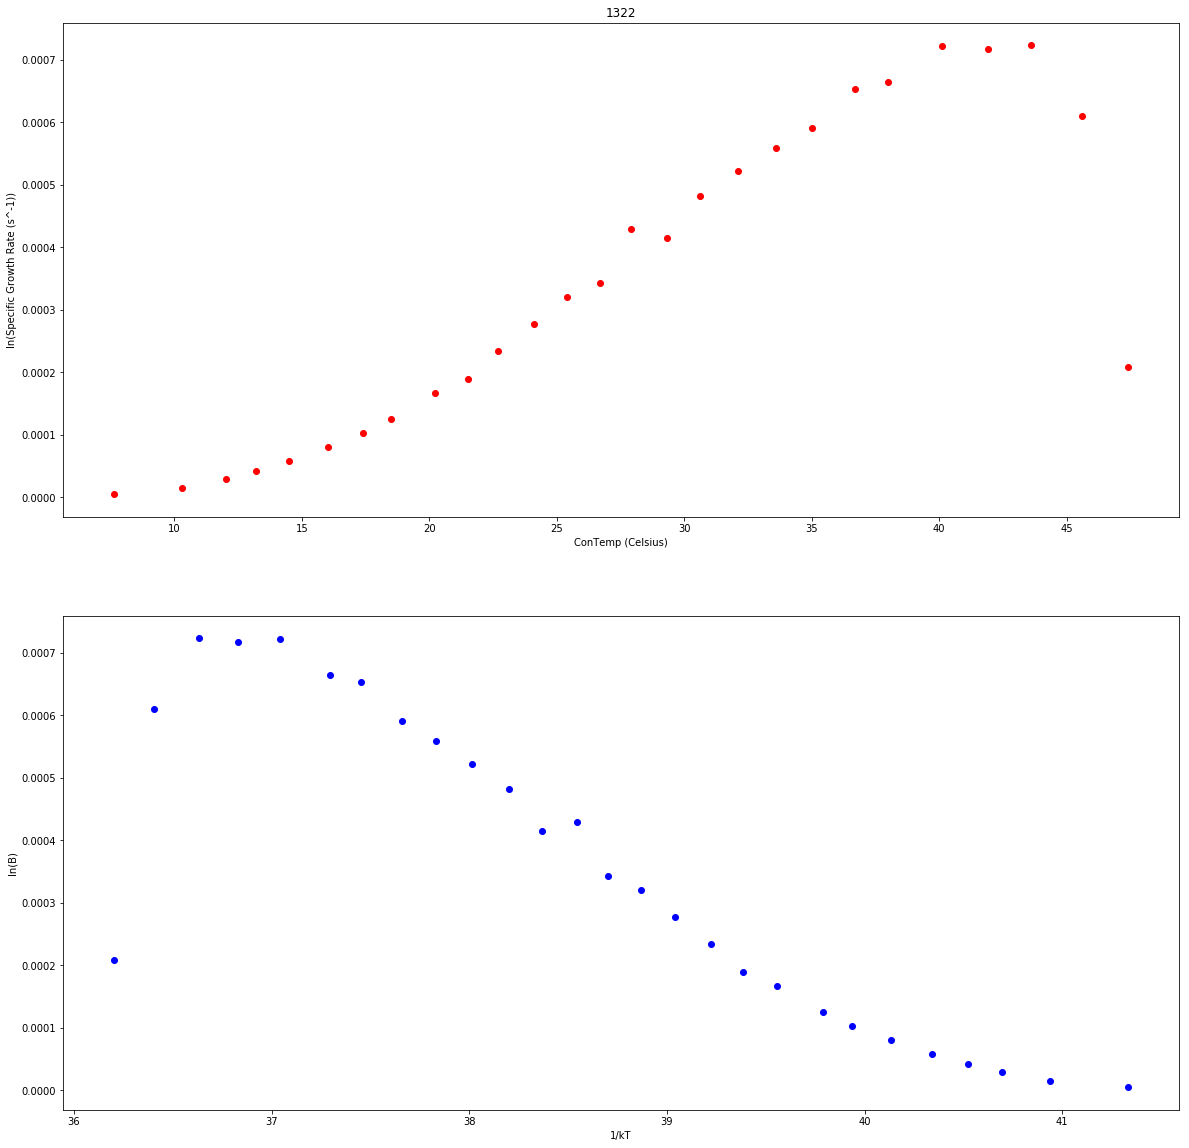

In [202]:
id = 1322

curveDF = data2[data2["NewID"] == id]

if curveDF["ConTemp"].isnull().any() == False:
    curveDF = curveDF.sort_values("ConTemp")
    x       = np.asarray(curveDF["ConTemp"])
    xtitle  = "ConTemp (" + curveDF["ConTempUnit"].iloc[0] + ")"
elif curveDF["AmbientTemp"].isnull().any() == False:
    curveDF = curveDF.sort_values("AmbientTemp")
    x       = np.asarray(curveDF["AmbientTemp"])
    xtitle  = "AmbientTemp (" + tmp["AmbientTempUnit"].iloc[0] + ")"
elif curveDF["ResTemp"].isnull().any() == False:
    curveDF = curveDF.sort_values("ResTemp")
    x       = np.asarray(curveDF["ResTemp"])
    xtitle  = "ResTemp (" + tmp["ResTempUnit"].iloc[0] + ")"

data    = np.asarray(curveDF["StandardisedTraitValue"])
ldata   = np.log(np.asarray(curveDF["StandardisedTraitValue"]))

ytitle = ("ln(" + curveDF["StandardisedTraitName"].iloc[0] + " (" +
          curveDF["StandardisedTraitUnit"].iloc[0] + "))")


adjx    = 1/((x+273.15)*constants.value('Boltzmann constant in eV/K'))
adjx    = np.flip(adjx, 0)
adjdata = np.flip(data, 0)






a = int(np.ceil(len(adjx)/4))

middlex = adjx[(a-1):len(x)-(a-1)]
middledata = adjdata[(a-1):len(x)-(a-1)]

El = stats.linregress(minx, mindata)[0]
E  = stats.linregress(middlex, middledata)[0]

Th = x[np.argmax(data)]  + 273.15  # using Topt
Tl = x.min() + 273.15

B0 = (stats.linregress(middlex, middledata)[0]*
                 (1/(283.15*constants.value('Boltzmann constant in eV/K'))) + 
                 stats.linregress(middlex, middledata)[1])

    
    
plt.figure(figsize = (20, 20))
plt.subplot(211)
plt.plot(x, data, 'ro')
plt.xlabel(xtitle)
plt.ylabel(ytitle)
plt.title(id)

plt.subplot(212)
plt.plot(adjx, adjdata, 'bo')
plt.xlabel("1/kT")
plt.ylabel("ln(B)")

plt.show

## General cubic polynomial model

$$ \large B = B_0 + B_1T + B_2T^2 + B_3T^3 $$

[[Fit Statistics]]
    # function evals   = 12
    # data points      = 27
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -516.067
    Bayesian info crit = -510.884
[[Variables]]
    a:   0.00054719 +/- 0.000161 (29.39%) (init= 0)
    b:  -9.8502e-05 +/- 2.11e-05 (21.38%) (init= 0)
    c:   5.3049e-06 +/- 8.26e-07 (15.57%) (init= 0)
    d:  -6.9275e-08 +/- 9.88e-09 (14.26%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(c, d)                      = -0.992 
    C(b, c)                      = -0.987 
    C(a, b)                      = -0.975 
    C(b, d)                      =  0.960 
    C(a, c)                      =  0.932 
    C(a, d)                      = -0.886 


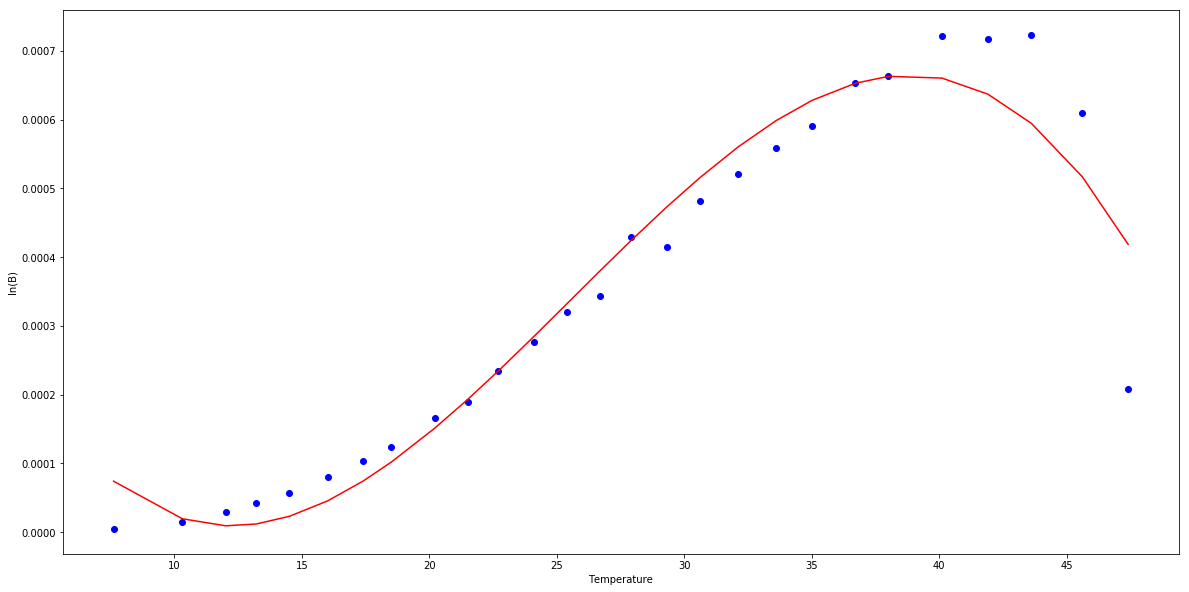

In [203]:
params = Parameters()
params.add('a', value = 0.)
params.add('b', value = 0.)
params.add('c', value = 0.)
params.add('d', value = 0.)

def get_residual(params, x, data):
    a = params['a'].value 
    b = params['b'].value
    c = params['c'].value 
    d = params['d'].value 
    
    model = a + b*x + c*x**2 + d*x**3
    
    return model - data

out1 = minimize(get_residual, params, args = (x, data))

report_fit(out1)

plt.plot(x, data, 'bo')
plt.plot(x, get_residual(out1.params, x, data) + data, 'r')
plt.ylabel("ln(B)")
plt.xlabel("Temperature")

plt.show()

## Schoolfield Model (no Eh)

$$ \large B = \frac{B_0e^{\frac{-E}{k}(\frac{1}{T} - \frac{1}{283.15})}}{1 + e^{\frac{-E_l}{k}(\frac{1}{T_l}-\frac{1}{T})}} $$

[[Fit Statistics]]
    # function evals   = 44
    # data points      = 27
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -468.130
    Bayesian info crit = -462.946
[[Variables]]
    B0:   0.00014583 +/- 0        (0.00%) (init=-0.0001535465)
    E:    0.33953425 +/- 0        (0.00%) (init=-0.0002255503)
    El:   0.36488299 +/- 0        (0.00%) (init= 0.364883)
    Tl:   280.760000 +/- 0        (0.00%) (init= 280.76)
    e:    2.718282 (fixed)
    k:    8.61733e-05 (fixed)


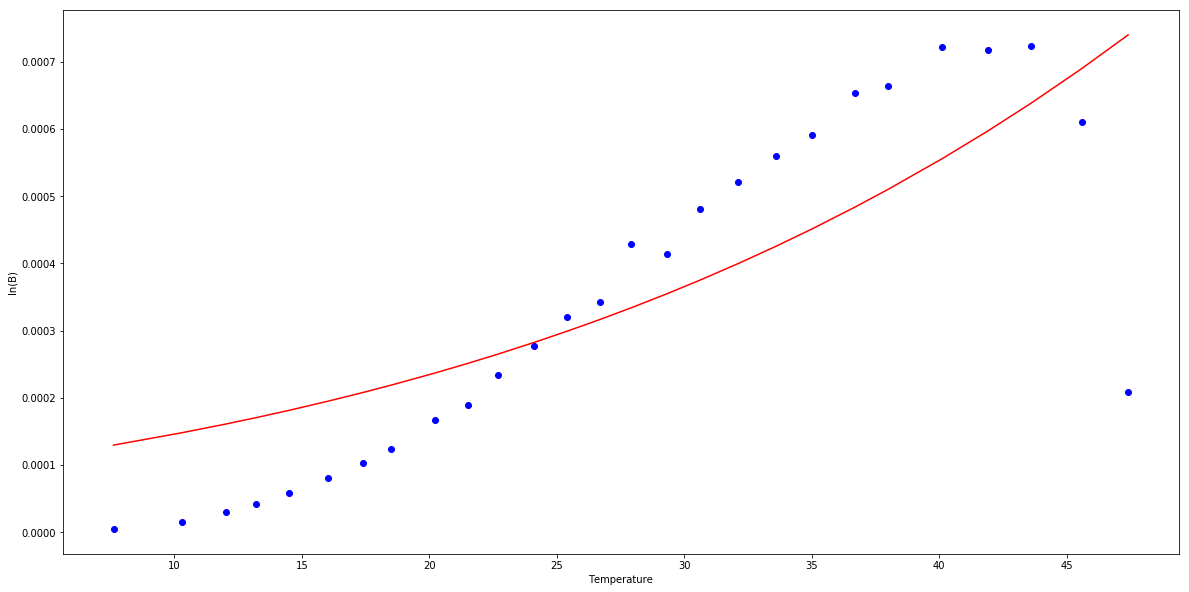

In [204]:
sparams = Parameters()
sparams.add('B0', value = B0)
sparams.add('E',  value = E)
sparams.add('El', value = El)
sparams.add('Tl', value = Tl, min = 260, max = 330)
sparams.add('e',  value = np.exp(1), vary = False)
sparams.add('k',  value = constants.value('Boltzmann constant in eV/K'), vary = False)

def schlfld_residual(sparams, x, data):
    B0 = sparams['B0'].value 
    E  = sparams['E'].value 
    El = sparams['El'].value 
    Tl = sparams['Tl'].value
    
    e = sparams['e'].value
    k = sparams['k'].value
    
    model = (B0*e**((-E/k)*((1/(x+ 273.15))-(1/283.15))))/(1+e**((El/k)*((1/Tl)-(1/x+273.15))))
        
    return model - data


out2 = minimize(schlfld_residual, sparams, args = (x, data))

report_fit(out2)

plt.plot(x, data, 'bo')
plt.plot(x, schlfld_residual(out2.params, x, data) + data, 'r')
plt.ylabel("ln(B)")
plt.xlabel("Temperature")
plt.show()

## Enzyme-assisted Arrhenius model

$$ \large V = A_0e\frac{-(E_b-(E_{\Delta H}(1 - \frac{T}{T_m}) + E_{\Delta Cp}(T - T_m - T\ln\frac{T}{T_m})))}{kT} $$

[[Fit Statistics]]
    # function evals   = 74
    # data points      = 27
    # variables        = 5
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -483.784
    Bayesian info crit = -477.305
[[Variables]]
    A0:   1.0000e-05 +/- 0        (0.00%) (init= 1e-05)
    Eb:  -1.4485e-10 +/- 0        (0.00%) (init= 1e-05)
    Ec:   8.9015e-11 +/- 0        (0.00%) (init= 1e-05)
    Eh:  -1.0065e-09 +/- 0        (0.00%) (init= 1e-05)
    Tm:   307.175037 +/- 0        (0.00%) (init= 290)
    e:    2.718282 (fixed)
    k:    8.61733e-05 (fixed)


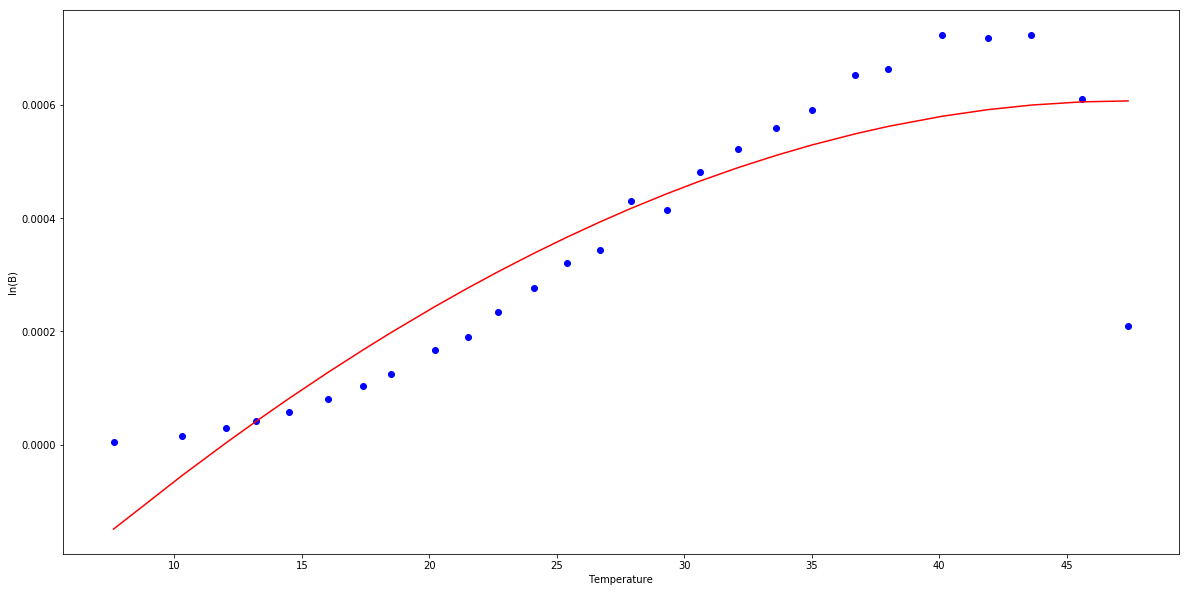

In [205]:
aparams = Parameters()
aparams.add('A0', value = 0.00001)
aparams.add('Eb', value = 0.00001)
aparams.add('Ec', value = 0.00001)
aparams.add('Eh', value = 0.00001)
aparams.add('Tm', value = 290, min = 260, max = 330)
aparams.add('e', value = np.exp(1), vary = False)
aparams.add('k', value = constants.value('Boltzmann constant in eV/K'), vary = False)

def arrhenius_residual(aparams, xVals, yVals):
    A0 = aparams['A0'].value 
    Eb = aparams['Eb'].value
    Ec = aparams['Ec'].value
    Eh = aparams['Eh'].value
    Tm = aparams['Tm'].value
    e  = aparams['e'].value
    k  = aparams['k'].value
    
    model = -(Eb-(Eh*(1-((x+273.15)/Tm))+Ec*((x+273.15)-Tm-(x+273.15)*np.log((x+273.15)/Tm))))/k*(x+273.15)
    
    return model - data

out3 = minimize(arrhenius_residual, aparams, args = (x, data))

report_fit(out3)

plt.plot(x, data, 'bo')
plt.plot(x, arrhenius_residual(out3.params, x, data) + data, 'r')
plt.ylabel("ln(B)")
plt.xlabel("Temperature")
plt.show()